<a href="https://colab.research.google.com/github/VSKuz/VSKuz/blob/Purchase-count-prediction-model/%D0%9A%D1%83%D0%B7%D0%BD%D0%B5%D1%86%D0%BE%D0%B2_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0%2C_%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_3_%D1%82%D0%B2%D0%BE%D1%80%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# На основе датасета [Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) я создам модель, предсказывающую количество покупок в магазинах, в зависимости от дохода, образования и количества членов семьи

# Блок с импортом библиотек

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, classification_report, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier

# Загружаем датасет

In [4]:
path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
print("Path to dataset files:", path) #Узнаём путь к загруженному файлу

100%|██████████| 62.0k/62.0k [00:00<00:00, 35.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/imakash3011/customer-personality-analysis/versions/1


In [5]:
# Читаем файл и задаём переменную data
data = pd.read_csv('/root/.cache/kagglehub/datasets/imakash3011/customer-personality-analysis/versions/1/marketing_campaign.csv', sep="\t")

# Изучение и предобработака датасета

In [6]:
#Знакомимся с содержимым датасета
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
#Сбрасываем строки с NULL (они были в колонке income)
data.dropna(inplace=True)

Преобразую датасет под мои нужды.

In [8]:
data["Marital_Status"].unique() #Смотрим категории "семейного положения"

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [9]:
#Если в браке или встречаются, то 2 человека, если одиночка, то 1
replace_vals = ['Together', 'Married']
data['Marital_Status'] = data['Marital_Status'].apply(lambda val: 2 if val in replace_vals else 1)

In [10]:
#Считаем количество членов семьи вместе с детьми и сохраняем в отдельный столбец
data["family_count"] = data["Marital_Status"] + data["Kidhome"] + data["Teenhome"]

In [11]:
#Преобразую информацию об образовании в вид, подходящий для обучения
label_encoder = LabelEncoder()
data['Education'] = label_encoder.fit_transform(data['Education'])
data['Education'].unique()

array([2, 4, 3, 1, 0])

Оставлю тут альтернативный вариант преобразования данных, в образовательных целях

если значение == PhD, то 1, а остальное 0

data['Education'] = np.where(data['Education'] == 'PhD', 1, 0)

In [12]:
#Посчитаю сумму покупок и сохраню результат отдельным столбцом
data['purchase_sum'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
data['purchase_sum'].head()

,purchase_sum
0,1617
1,27
2,776
3,53
4,422


## Выделяю датафрейм для обучения с нужными мне колонками

In [22]:
df = data[["family_count", 'purchase_sum', 'Education', 'Income', 'Recency']]

##Посмотрим зависимости количества покупок от дохода, количества членов семьи и времени с момента последней покупки

In [13]:
dfp = df[['purchase_sum', 'Income','family_count', 'Recency']]

<Axes: xlabel='purchase_sum', ylabel='Income'>

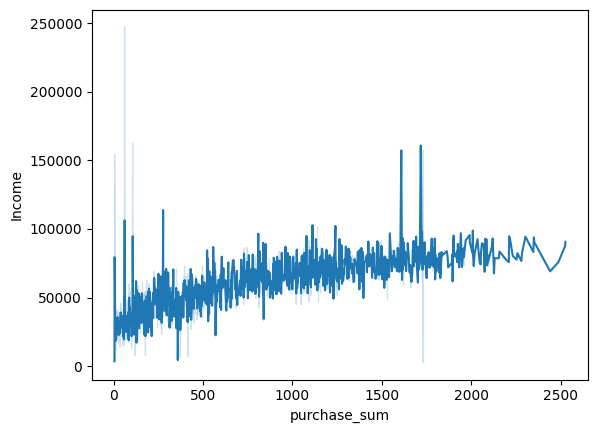

In [16]:
sns.lineplot(data=dfp, x="purchase_sum", y="Income")

В этом магазине богачи не особо много закупаются

<Axes: xlabel='family_count', ylabel='purchase_sum'>

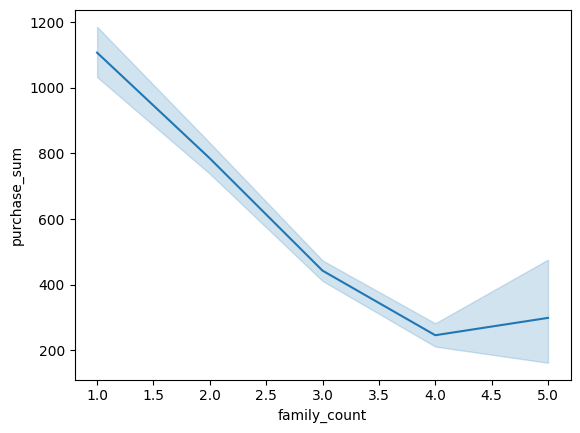

In [17]:
sns.lineplot(data=dfp, x="family_count", y="purchase_sum")

На удивление, многодетные семьи покупают даже меньше... Экономят либо дело в категориях товаров?

<Axes: xlabel='Recency', ylabel='purchase_sum'>

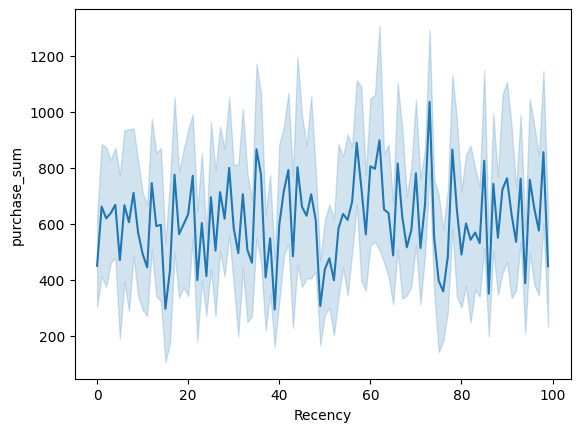

In [21]:
sns.lineplot(data=dfp, x="Recency", y="purchase_sum")

Ожидал более выраженное влияние количества дней с последней покупки на количество купленных товаров... те, кто закупился через 50 дней особенно выделились малым количеством купленных товаров... Однако, в среднем, количество купленных товаров в среднем растёт где-то до промежутка в 75 дней.

# Создание выборок

In [ ]:
#Нормализирую большие значения (приводжу в диапазон от 0 до 1)
scale_counts = MinMaxScaler()
df['Income'] = scale_counts.fit_transform(df[['Income']])
df['purchase_sum'] = scale_counts.fit_transform(df[['purchase_sum']])

<ipython-input-434-ef2695bff531>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Income'] = scale_counts.fit_transform(df[['Income']])
<ipython-input-434-ef2695bff531>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['purchase_sum'] = scale_counts.fit_transform(df[['purchase_sum']])


In [ ]:
# Разделяю датасет на признаки и метки
X = df.drop(['purchase_sum'], axis=1)
y = df[['purchase_sum']]

In [ ]:
#Делю признаки и метки на обучающую и проверочную часть
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#Привожу признаки в пригодный для обучения вид
scaler = StandardScaler()
col_sc = ['family_count', 'Education', 'Recency']
scaler.fit(X_train[col_sc])
X_train[col_sc] = scaler.transform(X_train[col_sc])
X_test[col_sc] = scaler.transform(X_test[col_sc])
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

# Задаю архитектуру, обучаю модель и оцениваю качество предсказаний

In [ ]:
xgb = XGBRegressor(max_depth = 1, n_estimators = 70, learning_rate = 0.75) #Архитектура
xgb.fit(X_train , y_train) #Обучение
y_pred = xgb.predict(X_test) #Предсказание на проверочной части

Оценка качества предсказания модели

In [ ]:
print('R²:', r2_score(y_test, y_pred)) #Мера совпадения предсказанных значений с фактическими
print('mean_squared_error:', mean_squared_error(y_test, y_pred)) #Мера оценки ошибок модели

R²: 0.7561733123614416
mean_squared_error: 0.25186834500866895
